# Dog Breed Classification using Transfer Learning
## Introduction
Transfer learning would likely reduce the amount of data and computation time needed to achieve good performance on this specific task. The following paper used transfer learning with InceptionResNetV2 as the base model:

*Ráduly, Zalán, et al. "Dog breed identification using deep learning." 2018 IEEE 16th International Symposium on Intelligent Systems and Informatics (SISY). IEEE, 2018.*

They achieved 90%+ accuracy and only fine-tuned the last fully-connected layer of InceptionResNetV2 while keeping other layers frozen.

The following is my implementation of their model using the hyperparameters and image augmentations they found to work. The following will be considered a baseline to compare all future models to. Hyperparemeter tuning will be explored later.

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

## Configuration
- I used 5/120 classes to test the code.

In [2]:
NUM_CLASSES = 5  # Change this to 120 for full dataset
NUM_EPOCHS = 30

BATCH_SIZE = 64 
LEARNING_RATE = 0.1
L2_REGULARIZATION_WEIGHT = 0.0001
NUM_CV_FOLDS = 5

## Data Loading

In [3]:
# http://vision.stanford.edu/aditya86/ImageNetDogs/ provide the train and test split in .mat files.
train_list = scipy.io.loadmat('/app/data/train_list.mat')
test_list = scipy.io.loadmat('/app/data/test_list.mat')

def extract_info(data_list, NUM_CLASSES=120):
    file_list = data_list['file_list']
    labels = data_list['labels'].squeeze() - 1  # Subtract 1 to make labels 0-119
    mask = labels < NUM_CLASSES
    file_paths = np.array([os.path.join('/app/data/Images', item[0][0]) for item in file_list[mask]])
    labels = labels[mask]
    return file_paths, labels

# Extract info for both train and test datasets
train_paths, train_labels = extract_info(train_list, NUM_CLASSES)
test_paths, test_labels = extract_info(test_list, NUM_CLASSES)

## Data Augmentation
The training images can be augmented to improve generalizability of the model by increasing the diversity of the training data. In the paper, they only reflected the image. This is also what I did. Although it would be interesting to compare metrics when also adding noise, varying brightness, etc. 

In [4]:
# Apply random augmentations to each image during training
augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
])

# Function to load and preprocess image
def load_and_preprocess_image(file_path, is_training=False):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    if is_training:
        # Apply augmentations to training images
        img = augmentation_layer(img)
    # Resize for Inception-ResNet-V2
    img = tf.image.resize(img, [299, 299])
    # Scale pixel values to [-1, 1] for Inception-ResNet-V2
    img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)
    return img

# Creates dataset pipeline that loads and processes images in batches
def create_dataset(file_paths, labels, is_training=False, batch_size=64, num_classes=120):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(file_paths))
    dataset = dataset.map(
        lambda x, y: (load_and_preprocess_image(x, is_training), tf.one_hot(y, num_classes)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

## Dataset Creation
The augmentations will be applied to the training dataset but not the test or validation datasets.

In [5]:
# Make datasets for training and testing the final model
train_dataset = create_dataset(train_paths, train_labels, is_training=True, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES)
test_dataset = create_dataset(test_paths, test_labels, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES)

# Check training set is balanced
unique, counts = np.unique(train_labels, return_counts=True)
print(f"Training dataset samples per class: Min: {np.min(counts)}, Max: {np.max(counts)}")

# Check testing set is balanced. 
unique, counts = np.unique(test_labels, return_counts=True)
print(f"Testing dataset samples per class: Min: {np.min(counts)}, Max: {np.max(counts)}")

print(f"Total number of training samples: {len(train_paths)}")
print(f"Total number of test samples: {len(test_paths)}")

Training dataset samples per class: Min: 100, Max: 100
Testing dataset samples per class: Min: 49, Max: 152
Total number of training samples: 500
Total number of test samples: 452


## Visualise Data Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


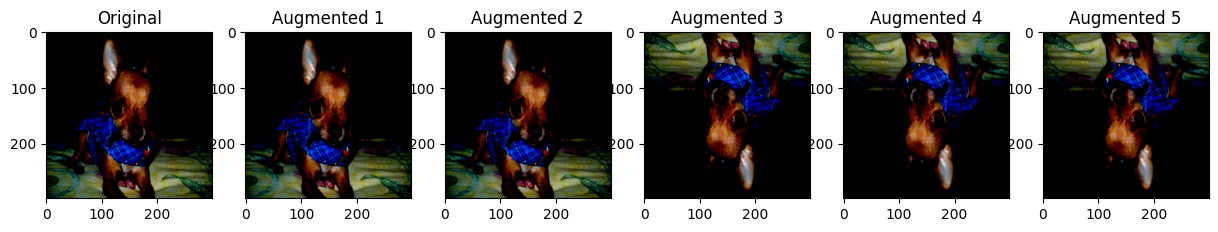

In [6]:
image_path = train_paths[0]
num_augmentations=5
original_image = load_and_preprocess_image(image_path, is_training=False)
augmented_images = [load_and_preprocess_image(image_path, is_training=True) for _ in range(num_augmentations)]

plt.figure(figsize=(15, 3))
plt.subplot(1, num_augmentations + 1, 1)
plt.imshow(original_image)
plt.title("Original")

for i, aug_image in enumerate(augmented_images, start=2):
    plt.subplot(1, num_augmentations + 1, i)
    plt.imshow(aug_image)
    plt.title(f"Augmented {i-1}")

plt.show()

## Training Process
### Model
InceptionResNetV2 was used as the base model. I froze the weights and removed the original top layer. I added my own custom top layer consisting of a global average pooling layer and a dense layer with softmax activation for classifying NUM_CLASSES classes. The only trainable parameters are the weights and biases of this layer.

### Hyperparameters
As mentioned, I will begin by implementing the model as described in the paper (listed below). Any future would would use this as a baseline with which to measure any future work to optimise hyperparameters.
- Learning rate: Exponentially decreasing from 0.1 with a decay rate of 10% every 3 epochs
- Epochs: 30
- Batch size: 64
- L2 regularization weight decay: 0.0001
- Nesterov momentum optimizer
- Softmax Cross-Entropy loss so I will use categorical_crossentropy

In [7]:
# Learning rate schedule
def lr_schedule(epoch):
    initial_lr = LEARNING_RATE
    drop_rate = 0.9
    epochs_drop = 3.0
    lr = initial_lr * (drop_rate ** (epoch // epochs_drop))
    return float(lr)

# Evaluate the unaugmented unaugmented training data after each epoch
class TrainEvalCallback(tf.keras.callbacks.Callback):
    def __init__(self, eval_dataset):
        super().__init__()
        self.eval_dataset = eval_dataset
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        eval_results = self.model.evaluate(self.eval_dataset, verbose=0)
        logs['unaugmented_train_loss'] = eval_results[0]
        logs['unaugmented_train_accuracy'] = eval_results[1]

# Define the number of folds
skf = StratifiedKFold(n_splits=NUM_CV_FOLDS, shuffle=True, random_state=42)

# Lists to store results
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
unaugmented_train_accuracies = []

for fold, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Fold {fold + 1}/{NUM_CV_FOLDS}")
    
    # Split the data
    train_paths_fold = train_paths[train_index]
    train_labels_fold = train_labels[train_index]
    val_paths_fold = train_paths[val_index]
    val_labels_fold = train_labels[val_index]
    
    # Create datasets
    train_dataset = create_dataset(train_paths_fold, train_labels_fold, is_training=True, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES)
    val_dataset = create_dataset(val_paths_fold, val_labels_fold, is_training=False, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES)

    # Make a seperate training dataset without augmenting the iamges to make a fair comparison with the validation set.
    train_dataset_eval = create_dataset(train_paths_fold, train_labels_fold, is_training=False, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES)
    train_eval_callback = TrainEvalCallback(train_dataset_eval)
    
    # Base model
    base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False

    # Reduce 3D tensor (w x h x channels) to a 1D vector by taking the average of each feature map
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION_WEIGHT))(x)
    model = tf.keras.Model(base_model.input, x)
    
    # Compile model
    optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=NUM_EPOCHS,
        validation_data=val_dataset,
        callbacks=[
            tf.keras.callbacks.LearningRateScheduler(lr_schedule),
            train_eval_callback
        ],
        verbose=1
    )
    
    # Store results
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    unaugmented_train_accuracies.append(history.history['unaugmented_train_accuracy'])

# Print average results
print(f"Average Train Accuracy: {np.mean(train_accuracies):.4f} ± {np.std(train_accuracies):.4f}")
print(f"Average Validation Accuracy: {np.mean(val_accuracies):.4f} ± {np.std(val_accuracies):.4f}")
print(f"Average Unaugmented Train Accuracy: {np.mean(unaugmented_train_accuracies):.4f} ± {np.std(unaugmented_train_accuracies):.4f}")

# After k-fold cross-validation, train on all data and evaluate on test set
full_train_dataset = create_dataset(train_paths, train_labels, is_training=True, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES)

train_dataset_eval = create_dataset(train_paths, train_labels, is_training=False, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES)
train_eval_callback = TrainEvalCallback(train_dataset_eval)

# Base model
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION_WEIGHT))(x)
model = tf.keras.Model(base_model.input, x)

optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train on full dataset
model.fit(
    full_train_dataset,
    epochs=NUM_EPOCHS,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lr_schedule),
        train_eval_callback
    ],
    verbose=1
)

# Save the trained model
model.save('/app/models/dog_breed_classifier.keras')

# Save in SavedModel format for TensorFlow Serving
tf.saved_model.save(model, "/app/saved_model/1")

print("Model saved in both Keras and SavedModel formats")

Fold 1/5
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 171s 24s/step - accuracy: 0.4983 - loss: 1.2671 - val_accuracy: 0.9200 - val_loss: 0.3351 - learning_rate: 0.1000 - unaugmented_train_loss: 0.2955 - unaugmented_train_accuracy: 0.9600
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 150s 23s/step - accuracy: 0.8195 - loss: 0.5884 - val_accuracy: 0.9400 - val_loss: 0.1705 - learning_rate: 0.1000 - unaugmented_train_loss: 0.1215 - unaugmented_train_accuracy: 0.9775
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 148s 23s/step - accuracy: 0.9338 - loss: 0.2407 - val_accuracy: 0.9700 - val_loss: 0.1179 - learning_rate: 0.1000 - unaugmented_train_loss: 0.1113 - unaugmented_train_accuracy: 0.9775
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 151s 23s/step - accuracy: 0.9095 - loss: 0.2893 - val_accuracy: 0.9500 - val_loss: 0.1353 - learning_rate: 0.0900 - unaugmented_train_loss: 0.0866 - unaugmented_train_accuracy: 0.9775
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 151s 23s/step - accur

INFO:tensorflow:Assets written to: /app/saved_model/1/assets


Model saved in both Keras and SavedModel formats


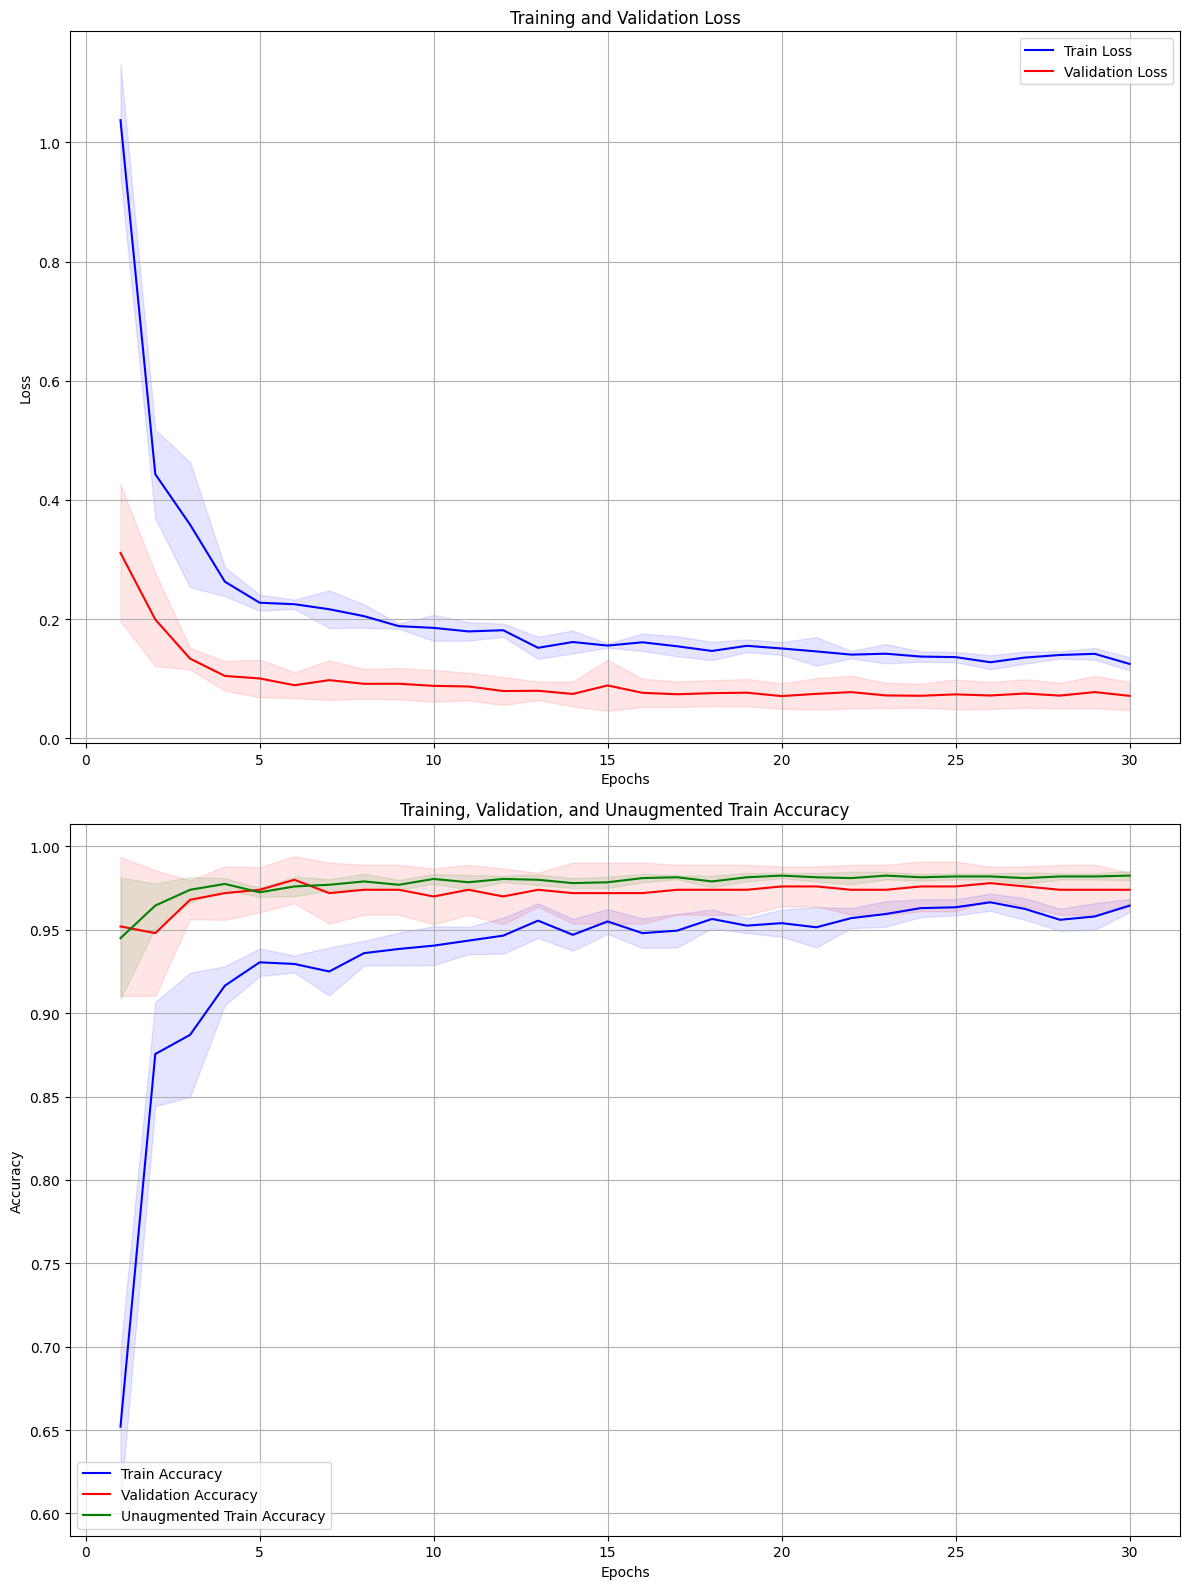

In [8]:
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies, unaugmented_train_accuracies):
    epochs = range(1, len(train_losses[0]) + 1)
    
    # Calculate mean and std for each metric
    mean_train_loss = np.mean(train_losses, axis=0)
    std_train_loss = np.std(train_losses, axis=0)
    mean_val_loss = np.mean(val_losses, axis=0)
    std_val_loss = np.std(val_losses, axis=0)
    
    mean_train_acc = np.mean(train_accuracies, axis=0)
    std_train_acc = np.std(train_accuracies, axis=0)
    mean_val_acc = np.mean(val_accuracies, axis=0)
    std_val_acc = np.std(val_accuracies, axis=0)
    mean_unaugmented_train_acc = np.mean(unaugmented_train_accuracies, axis=0)
    std_unaugmented_train_acc = np.std(unaugmented_train_accuracies, axis=0)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    
    # Plot loss
    ax1.plot(epochs, mean_train_loss, 'b-', label='Train Loss')
    ax1.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.1, color='b')
    ax1.plot(epochs, mean_val_loss, 'r-', label='Validation Loss')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.1, color='r')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(epochs, mean_train_acc, 'b-', label='Train Accuracy')
    ax2.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, alpha=0.1, color='b')
    ax2.plot(epochs, mean_val_acc, 'r-', label='Validation Accuracy')
    ax2.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.1, color='r')
    ax2.plot(epochs, mean_unaugmented_train_acc, 'g-', label='Unaugmented Train Accuracy')
    ax2.fill_between(epochs, mean_unaugmented_train_acc - std_unaugmented_train_acc, mean_unaugmented_train_acc + std_unaugmented_train_acc, alpha=0.1, color='g')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Training, Validation, and Unaugmented Train Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies, unaugmented_train_accuracies)

## Evaluation Final Model
### Metrics Used
- Accuracy: The test set is not perfectly balanced, each of the 120 classes has between 52 and 152 samples. However, accuracy is still useful but maybe slightly biased towards classes with more samples.
- Precision, recall, and F1-score
- Confusion matrix to identify commonly confused breeds

In [9]:
# Evaluate on test set
print("Evaluating on test dataset:")
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Extract true classes
true_classes = []
for x, y in test_dataset:
    true_classes.extend(np.argmax(y.numpy(), axis=1))
true_classes = np.array(true_classes)

# Print classification report and confusion matrix
print(classification_report(true_classes, predicted_classes))
print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

# Check prediction confidence
prediction_confidence = np.max(predictions, axis=1)
print(f"Average prediction confidence: {np.mean(prediction_confidence):.4f}")
print(f"Min prediction confidence: {np.min(prediction_confidence):.4f}")
print(f"Max prediction confidence: {np.max(prediction_confidence):.4f}")

# Calculate and print test accuracy
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

Evaluating on test dataset:
8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 10s/step


2024-09-17 12:24:46.362863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       0.99      0.96      0.98        85
           2       0.99      0.97      0.98       152
           3       0.92      0.94      0.93        49
           4       0.93      0.96      0.95       114

    accuracy                           0.97       452
   macro avg       0.96      0.97      0.96       452
weighted avg       0.97      0.97      0.97       452

Confusion Matrix:
[[ 52   0   0   0   0]
 [  1  82   0   1   1]
 [  0   0 147   0   5]
 [  0   1   0  46   2]
 [  0   0   1   3 110]]
Average prediction confidence: 0.9652
Min prediction confidence: 0.4964
Max prediction confidence: 0.9992
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - accuracy: 0.9701 - loss: 0.0950
Test accuracy: 0.9668
Test loss: 0.1064


## Results and Evaluation
Note: Only 5/120 classes were run due to computational constraints.

- Expected accuracy based on the reference paper: ~90% on the test set with 120 classes
- The results I achieved outperformed this, though this is almost certainly because I made the problem easier by using fewer classes
- If the model was overfitting I would have expected to see worse performance on the validation and test data, however I would still proceed with caution and would seek to validate the model on out-of-distribution data. I would also train the model on the entire dataset where I would expect the accuracy to be closer to ~90% given the results in the reference paper.
- It would also be interesting to explore the samples that the model was least confident about.
